<a href="https://colab.research.google.com/github/xvmon234-ai/Learning-Python/blob/main/Financial_Risk_Prediction/05_Model_Interpretation_Practical_Application/Model_Interpretation_Practical_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **모델 해석 및 실무적 활용 방안(Model Interpretation & Practical Application)**


---


### **1단계: 데이터 준비 및 모델 훈련**
먼저, 이전 단계에서 작성한 코드를 다시 실행하여 모델 학습에 필요한 데이터를 준비하고 모델을 훈련합니다. 이 과정이 완료되어야 모델을 해석할 수 있습니다.

In [1]:
# 필요한 라이브러리 불러오기
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1 단계: 데이터 수집
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
financial_data = {}

for ticker in tickers:
  try:
    stock = yf.Ticker(ticker)
    income_stmt = stock.income_stmt.T
    balance_sheet = stock.balance_sheet.T
    financial_data[ticker] = {'income_stmt': income_stmt, 'balance_sheet': balance_sheet} # 질문 01. 해당 내용에 대한 추가설명
  except Exception as e:
        print(f"{ticker}의 데이터를 불러오는 중 오류가 발생했습니다: {e}")

# 2 단계: 재무 비율 계산

calculated_ratios = {}

for ticker in tickers:
  if ticker in financial_data:
    income_df = financial_data[ticker]['income_stmt']
    balance_df = financial_data[ticker]['balance_sheet']

    # DataFrame 복사본을 생성하여 오류 방지
    income_df = income_df.copy()
    balance_df = balance_df.copy()

    # 각 기업별 재무 비율 계산
    ratios_df = pd.DataFrame(index=income_df.index)

    # 1. 유동성 비율 (Liquidity Ratios)
    # 유동비율 = 유동자산 / 유동부채: 단기 채무 지급 능력을 나타냄.
    ratios_df['CurrentRatio'] = balance_df['Current Assets'] / balance_df['Current Liabilities']

    # 당좌비율 = (유동자산 - 재고자산) / 유동부채: 재고를 제외한 엄격한 단기 지급 능력.
    # META의 경우 재고자산이 없으므로 재고자산을 0으로 간주하여 계산해야 함
    # 따라서 다음의 조건문을 활용
    if 'Inventory' in balance_df.columns:
      ratios_df['QuickRatio'] = (balance_df['Current Assets'] - balance_df['Inventory']) / balance_df['Current Liabilities']
    # 재고자산이 없는 경우
    # 업종에 따라서 이와 같은 경우가 존재할 수 있음을 유의해야함
    else:
      ratios_df['QuickRatio'] = balance_df['Current Assets'] / balance_df['Current Liabilities']

    # 2. 수익성 비율 (Profitability Ratios)
    # 매출총이익률 = 매출총이익 / 매출(OperatingRevenue): 주된 영업활동을 통해 얻은 수익성.
    ratios_df['GrossProfitMargin'] = income_df['Gross Profit'] / income_df['Operating Revenue']

    # 영업이익률 = 영업이익 / 매출(Operating Revenue): 핵심 사업의 효율성.
    ratios_df['OperatingProfitMargin'] = income_df['Operating Income'] / income_df['Operating Revenue']

    # 3. 레버리지 비율 (Leverage Ratios)
    # 부채비율 = 총부채 / 총자본(Common Stock Equity): 타인자본 의존도를 나타냄.
    ratios_df['DebtRatio'] = balance_df['Total Debt'] / balance_df['Common Stock Equity']

# 3단계: 목표 변수(Target) 생성
    # 다음 해에 순이익이 음수이면 '1' (재무 위험), 아니면 '0' (정상)으로 정의
    # shift(-1)을 사용하여 다음 연도 데이터를 가져옴
    net_income_next_year = income_df['Net Income'].shift(-1)
    ratios_df['FinancialRisk'] = (net_income_next_year < 0).astype(int)

    # 계산된 재무 비율 저장
    calculated_ratios[ticker] = ratios_df

all_ratios_df = pd.concat(calculated_ratios, names=['Ticker', 'Date'])
all_ratios_df = all_ratios_df.reset_index()

# 결측치 제거
all_ratios_df = all_ratios_df.dropna()

# 독립 변수(X)와 종속 변수(y) 정의
X = all_ratios_df[['CurrentRatio', 'QuickRatio', 'GrossProfitMargin', 'OperatingProfitMargin', 'DebtRatio']]
y = all_ratios_df['FinancialRisk']

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 선택 및 훈련 (Random Forest 모델 사용)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("✅ 데이터 준비 및 모델 훈련 완료.")

✅ 데이터 준비 및 모델 훈련 완료.


### **2단계: 모델 해석: 특성 중요도(Feature Importance) 분석 및 시각화**
이제 훈련된 모델을 분석하여 어떤 재무 비율이 가장 중요한지 파악합니다.

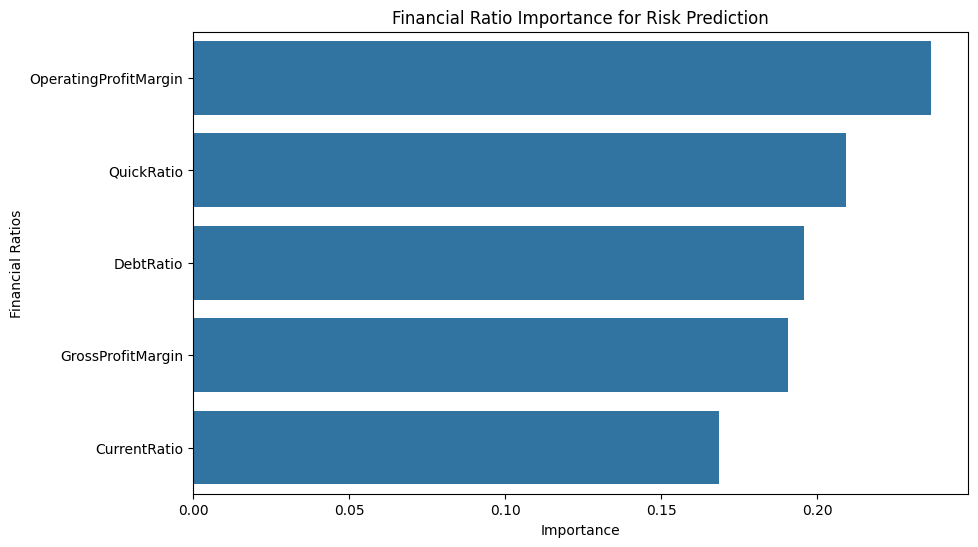


✅ 모델의 주요 특성 중요도:
OperatingProfitMargin    0.236452
QuickRatio               0.209114
DebtRatio                0.195575
GrossProfitMargin        0.190478
CurrentRatio             0.168381
dtype: float64


In [2]:
# 특성 중요도 추출
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# 중요도 순서대로 정렬
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_sorted, y=feature_importances_sorted.index)
plt.title('Financial Ratio Importance for Risk Prediction')
plt.xlabel('Importance')
plt.ylabel('Financial Ratios')
plt.show()

print("\n✅ 모델의 주요 특성 중요도:")
print(feature_importances_sorted)

> **코드 해설:**
>
> * model.feature_importances_: 랜덤 포레스트 모델이 학습 과정에서 계산한 각 특성(재무 비율)의 중요도를 배열 형태로 반환합니다.
>
> * pd.Series(..., index=X.columns): 중요도 배열에 컬럼 이름(재무 비율 이름)을 붙여서 데이터프레임의 형태로 만듭니다.
>
> * sns.barplot(): 시각적으로 막대 그래프를 그려서 어떤 비율이 가장 중요한지 한눈에 파악할 수 있게 합니다.